This program is a study on etf analysis strategy from the book <<以Python取勝 — 計量交易快速上手>>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import math

Download Dow Jones Industrial Average ETF data using yahoo finance api 

In [2]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "DIA",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        #period = "5y",
        start="2015-11-02", end="2020-10-30",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-11-02 to 2020-10-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB
None
                  Open        High         Low       Close   Volume
Date                                                               
2015-11-02  156.563526  157.820494  156.439600  157.670013  4178300
2015-11-03  157.492949  158.980075  157.386731  158.510925  4284900
2015-11-04  158.953639  158.971333  157.732072  158.139252  6870400
2015-11-05  158.227681  158.670276  157.324784  158.130310  5008100
2015-11-06  157.997554  158.599476  157.307107  158.572922  7642800
<bound method NDFrame.tail of                   Open        High         Low       Cl

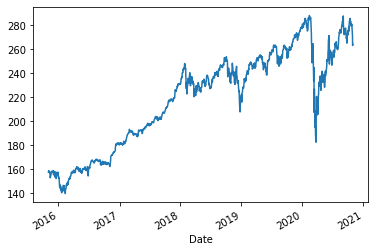

In [3]:
# check data quality
def conduct_eda(data_df):
    print(data_df.info())
    print(data_df.head())
    print(data_df.tail)
    data_df['Close'].plot()
conduct_eda(data)

In [4]:
def output_opt_result(data, clhl_start = 0.1, clhl_end = 1, clhl_step = 0.01, tc = 0.0005, min_trading_num=728):
    result = []
    data['r'] = data['Close'].pct_change()
    
    #try whole range of parameter in backtest
    for clhl_thres in np.arange(clhl_start, clhl_end + 0.00000001, clhl_step):
        try: 
            data['CLHL'] = (data['Close']-data['Low'])/(data['High']-data['Low'])
            data['position'] = np.where(data['CLHL']<clhl_thres, 1 ,0)
            data['tc'] = abs(data['position']-data['position'].shift(1))*tc
            data['pnl'] = data['position'].shift(1)*data['r']-data['tc']
            data['cum_pnl'] = data['pnl'].cumsum()
            trading_number = abs(data['position']).sum()
            SR = data['pnl'].mean()/data['pnl'].std()*math.sqrt(252)
            
            
        except:
            SR=-100
        if clhl_thres==0.88:
                print('teste')
                data.to_excel('data.xlsx')
        performance = {'CLHL_thres': clhl_thres, 'SR' : SR, 'trading_number':trading_number}
        result.append(performance)
        
    #optimise result
    result=pd.DataFrame(result)
    result_sort=result.sort_values('SR',ascending=False)
    result_sort.to_excel('sort.xlsx')
    result_sort = result_sort[result_sort['trading_number']>min_trading_num]
    clhl_opt = result_sort['CLHL_thres'].iloc[0]
    return clhl_opt

In [5]:
clhl_opt=output_opt_result(data)
clhl_opt

0.9699999999999995

In [6]:
def apply_param(data,lclhl_opt,tc=0.0005):
    data['CLHL'] = (data['Close']-data['Low'])/(data['High']-data['Low'])
    data['position'] = np.where(data['CLHL']<clhl_opt, 1 ,0)
    data['tc'] = abs(data['position']-data['position'].shift(1))*tc
    data['pnl'] = data['position'].shift(1)*data['r']-data['tc']
    data['cum_pnl'] = data['pnl'].cumsum()
    data['norm'] = data['r'].cumsum()
    return data

In [7]:
opt_data=apply_param(data,clhl_opt)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-11-02 to 2020-10-29
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1258 non-null   float64
 1   High      1258 non-null   float64
 2   Low       1258 non-null   float64
 3   Close     1258 non-null   float64
 4   Volume    1258 non-null   int64  
 5   r         1257 non-null   float64
 6   CLHL      1258 non-null   float64
 7   position  1258 non-null   int32  
 8   tc        1257 non-null   float64
 9   pnl       1257 non-null   float64
 10  cum_pnl   1257 non-null   float64
 11  norm      1257 non-null   float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 122.9 KB
None
                  Open        High         Low       Close   Volume         r  \
Date                                                                            
2015-11-02  156.563526  157.820494  156.439600  157.670013  4178300       NaN   
2015-11-03  157.49

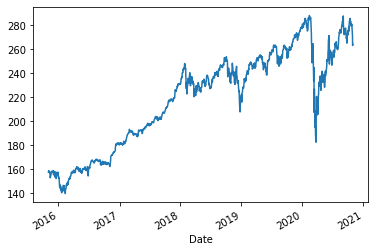

In [8]:
conduct_eda(opt_data)

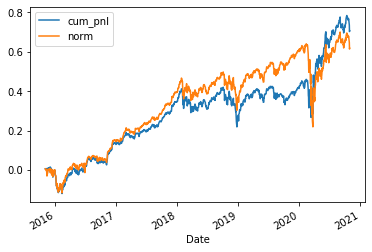

In [9]:
opt_data[['cum_pnl','norm']].plot()